In [64]:
%load_ext autoreload
%autoreload 2

import jax
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Dict, Optional

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jaxley as jx
from jaxley.channels import HH, Leak
from jaxley.connection import connect

from jaxley_mech.synapses.nhka14 import mGluR6, META
from jaxley_mech.channels.chen24 import Phototransduction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
META

{'reference_1': 'Nishiyama, S., Hosoki, Y., Koike, C., & Amano, A. (2014). IEEE, 6116-6119.',
 'reference_2': 'Witkovsky, P., Schmitz, Y., Akopian, A., Krizaj, D., & Tranchina, D. (1997). Journal of Neuroscience, 17(19), 7297-7306.'}

Added 1 external_states. See `.externals` for details.


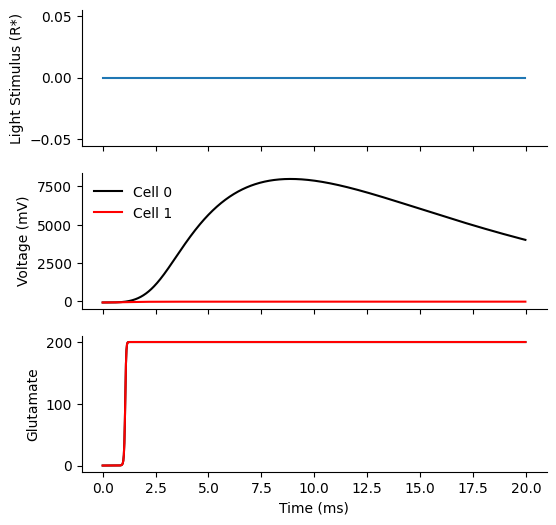

In [76]:
n_cells = 2
dt = 0.025
t_max = 20
_ = np.random.seed(0)

# Define a compartment, branch, and cell
comp = jx.Compartment()
branch = jx.Branch(comp, nseg=1)
cell = jx.Cell(branch, parents=[-1])

# Define the network and connectivity
network = jx.Network([cell for _ in range(n_cells)])
connect(
    network.cell(0).branch(0).comp(0), network.cell(1).branch(0).comp(0), mGluR6()
)

# Insert mechanisms
network.cell(0).insert(Leak())
network.cell(0).insert(Phototransduction())
network.cell(1).insert(Leak())

# Set voltages to resting membrane potential
network.cell([0, 1]).set("v", -70.0)

network.delete_recordings()
# Record voltage
network.cell(0).branch(0).comp(0).record(verbose=False)
network.cell(1).branch(0).loc(0).record(verbose=False)
# Record glutamate
network.cell(0).branch(0).comp(0).record("mGluR6_Glu", verbose=False)
network.cell(1).branch(0).loc(0).record("mGluR6_Glu", verbose=False)

# Design stimulus
time = np.arange(0, t_max, step=dt)
Jhv = np.zeros_like(time)
Jhv[100:150] = 0

# Clamp the phototransduction current
network.cell(0).clamp("Phototransduction_Stim", Jhv)

v = jx.integrate(network, t_max=t_max, delta_t=dt, solver="fwd_euler")

fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
colors = ["k", "r"]

_ = ax[0].plot(time, Jhv)
for i in range(2):
    ax[1].plot(time, v[i, :-1], color=colors[i], label=f"Cell {i}")
    ax[2].plot(time, v[i + 2, :-1], color=colors[i], label=f"Cell {i}")

ax[0].set_ylabel("Light Stimulus (R*)")
ax[1].set_ylabel("Voltage (mV)")
ax[1].legend(frameon=False)
ax[2].set_ylabel("Glutamate")
ax[2].set_xlabel("Time (ms)")

sns.despine();

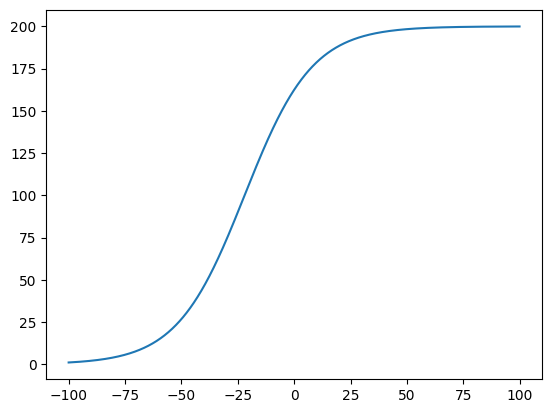

In [50]:
# Plot Glu release as a function of membrane potential
C_Glu = 200
V_half = -22
kGlu = 15
r_0 = 0
vs = np.arange(-100, 100, 0.1)
Glu = C_Glu / (1 + np.exp((V_half - vs)/kGlu)) + r_0
plt.plot(vs, Glu)
